# Numpyro Integration

In [1]:
import sys, os
sys.path.append("/home/emmanuel/contributions/GPJax")

import gpjax
import numpyro
import jax
import jax.numpy as jnp
import jax.random as jr
import tensorflow_probability.substrates.jax as tfp
import matplotlib.pyplot as plt
from jax import grad, jit

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

tfd = tfp.distributions
key = jr.PRNGKey(123)
print(gpjax.__version__)

%matplotlib inline
%load_ext autoreload
%autoreload 2

0.3.3


## Data

In [2]:
N = 50
noise = 0.2

x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

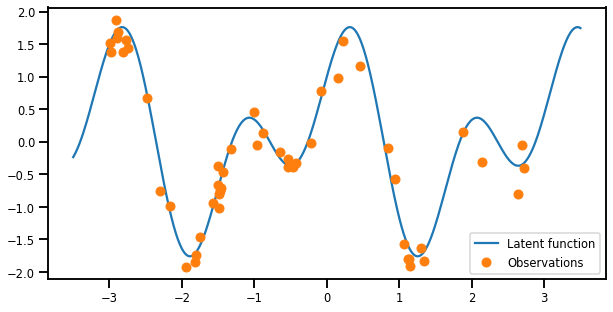

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(xtest, ytest, label="Latent function", color="tab:blue")
ax.plot(x, y, "o", label="Observations", color="tab:orange")
ax.legend(loc="best")
plt.show()

## Gaussian Process Regression Model

In [4]:
from gpjax.gps import Prior
from gpjax.kernels import RBF
from gpjax.likelihoods import Gaussian


kernel = RBF()
prior = Prior(kernel=kernel)

lik = Gaussian()
posterior = prior * lik

### Initialize Parameters

In [5]:
from gpjax.parameters import initialise

params = initialise(posterior)

print(params)

{'lengthscale': DeviceArray([1.], dtype=float64), 'obs_noise': DeviceArray([1.], dtype=float64), 'variance': DeviceArray([1.], dtype=float64)}


### Numpyro Style Parameters

In [6]:
from gpjax.interfaces.numpyro import add_constraints, numpyro_dict_params

In [7]:
numpyro_dict_params = numpyro_dict_params(params)
numpyro_dict_params

{'lengthscale': {'init_value': DeviceArray([1.], dtype=float64),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7febc3858ca0>},
 'obs_noise': {'init_value': DeviceArray([1.], dtype=float64),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7febc3858ca0>},
 'variance': {'init_value': DeviceArray([1.], dtype=float64),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7febc3858ca0>}}

### Adding Constraints

We can modify the parameters such that there are constraints.

#### Example I - All Positive

In [8]:
from numpyro.distributions import constraints

# example 1 - adding positive for everything
numpyro_dict_params_ = add_constraints(numpyro_dict_params, constraints.real)
numpyro_dict_params_

{'lengthscale': {'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._Real at 0x7febc3858dc0>},
 'obs_noise': {'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._Real at 0x7febc3858dc0>},
 'variance': {'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._Real at 0x7febc3858dc0>}}

### Example II - A specific Variable Real

In [9]:
# example 1 - adding positive for everything
numpyro_dict_params_ = add_constraints(numpyro_dict_params, "lengthscale", constraints.positive)
numpyro_dict_params_

{'lengthscale': {'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7febc3858ca0>},
 'obs_noise': {'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7feb9c7bc2b0>},
 'variance': {'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7feb9c7bc2b0>}}

### Example III - 1 interval, 1 greater than 

In [10]:
# example 1 - adding positive for everything
numpyro_dict_params_ = add_constraints(
    numpyro_dict_params, 
    ["lengthscale", "obs_noise"], 
    [constraints.greater_than(0.01), constraints.interval(0.1, 0.001)]
)
numpyro_dict_params_

{'lengthscale': {'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7feb9c7bc4f0>},
 'obs_noise': {'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._Interval at 0x7feb9c7bc4c0>},
 'variance': {'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7feb9c7bca30>}}

## Maximum Likelihood Estimation

In [11]:
from gpjax.interfaces.numpyro import numpyro_mle

nll_model = numpyro_mle(posterior, numpyro_dict_params)

with numpyro.handlers.seed(rng_seed=123):
    t = nll_model(x, y)

### Optimization

In [12]:
%%time
from numpyro.infer import SVI, Trace_ELBO

# reproducibility
rng_key = jax.random.PRNGKey(0)
n_iterations = 1_000

# initialize mle model
nll_model = numpyro_mle(posterior, numpyro_dict_params)

# numpyro specific optimizer
optimizer = numpyro.optim.Adam(step_size=0.01)

# stochastic variational inference (pseudo)
svi = SVI(nll_model, lambda x, y: None, optimizer, loss=Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(1), n_iterations, x, y)

100%|██████████| 1000/1000 [00:02<00:00, 354.86it/s, init loss: 3273.3523, avg. loss [951-1000]: 866.9415]


CPU times: user 7.45 s, sys: 45.5 s, total: 53 s
Wall time: 3.28 s


### Plotting the Loss

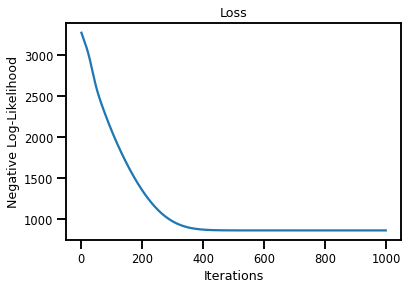

In [13]:
fig, ax = plt.subplots()

ax.plot(svi_results.losses);
ax.set(
    title = "Loss",
    xlabel="Iterations",
    ylabel="Negative Log-Likelihood"
    );
plt.show()

### Extracting the Parameters

In [14]:
from pprint import pprint
# Take them directly
learned_params = svi_results.params
pprint(learned_params)

{'lengthscale': DeviceArray([0.4268455], dtype=float64),
 'obs_noise': DeviceArray([0.03674606], dtype=float64),
 'variance': DeviceArray([1.23430812], dtype=float64)}


### Predictions

In [15]:
from gpjax import mean, variance

predictive_mean = mean(posterior, learned_params, xtest, x, y).squeeze()
predictive_covariance = variance(posterior, learned_params, xtest, x, y).squeeze()

mu = predictive_mean
one_stddev = 1.96 * jnp.sqrt(jnp.diag(predictive_covariance))

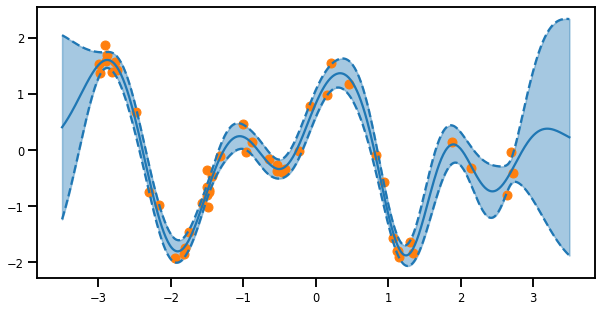

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu, color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.show()

## Maximum A Posteriori

### Prior Parameters

In [17]:
from gpjax.interfaces.numpyro import numpyro_map
import numpyro.distributions as dist

hyperpriors = {
    "lengthscale": dist.Gamma(1.0, 1.0),
    "variance": dist.Gamma(2.0, 2.0),
    "obs_noise": dist.Gamma(2.0, 2.0),
}

### GP Model

In [18]:
from numpyro.infer.autoguide import AutoDelta

# initialize mle model
nll_model = numpyro_map(posterior, hyperpriors)

# Delta Guide
guide = AutoDelta(nll_model)

### Optimization

In [19]:
%%time
from numpyro.infer import SVI, Trace_ELBO


# reproducibility
rng_key = jax.random.PRNGKey(0)
n_iterations = 1_000

# numpyro specific optimizer
optimizer = numpyro.optim.Adam(step_size=0.01)

# stochastic variational inference (pseudo)
svi = SVI(nll_model, guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(1), n_iterations, x, y)

100%|██████████| 1000/1000 [00:02<00:00, 400.79it/s, init loss: 3115.1381, avg. loss [951-1000]: 870.2245]


CPU times: user 9.93 s, sys: 43.3 s, total: 53.2 s
Wall time: 5.24 s


### Losses

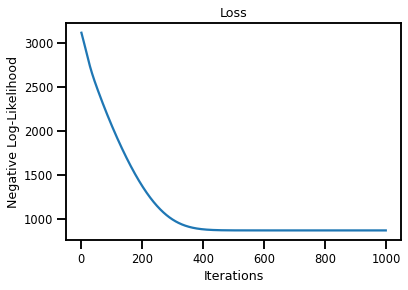

In [20]:
fig, ax = plt.subplots()

ax.plot(svi_results.losses);
ax.set(
    title = "Loss",
    xlabel="Iterations",
    ylabel="Negative Log-Likelihood"
    );
plt.show()

### Extracting the Parameters

In [21]:
from pprint import pprint
# Take them directly
learned_params = svi_results.params
pprint(learned_params)

{'lengthscale_auto_loc': DeviceArray(0.42614677, dtype=float64),
 'obs_noise_auto_loc': DeviceArray(0.03678401, dtype=float64),
 'variance_auto_loc': DeviceArray(1.22468053, dtype=float64)}


We can also take the median which will eliminate the need for the `auto_loc` names.

In [22]:
median_params = guide.median(learned_params) 
pprint(median_params)

{'lengthscale': DeviceArray(0.42614677, dtype=float64),
 'obs_noise': DeviceArray(0.03678401, dtype=float64),
 'variance': DeviceArray(1.22468053, dtype=float64)}


### Predictions

In [23]:
from gpjax import mean, variance

predictive_mean = mean(posterior, median_params, xtest, x, y).squeeze()
predictive_covariance = variance(posterior, median_params, xtest, x, y).squeeze()

mu = predictive_mean
one_stddev = 1.96 * jnp.sqrt(jnp.diag(predictive_covariance))

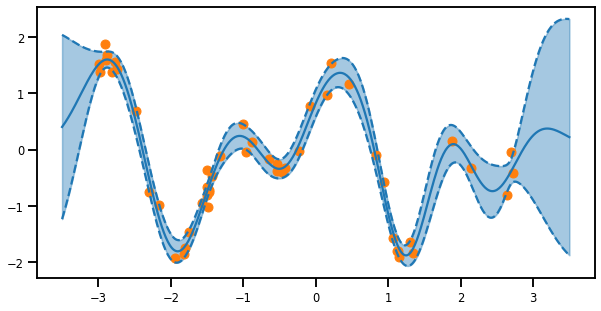

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu, color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.show()

## Hamiltonian Monte Carlo

### Model

In [25]:

# initialize mle model
nll_model = numpyro_map(posterior, hyperpriors)

### Sampling

Since we are doing sampling, there is no need to define a variational distribution.

In [26]:
from numpyro.infer import MCMC, NUTS



# reproducibility
rng_key = jax.random.PRNGKey(0)

# NUTS Parameters
n_samples = 1_000
n_warmup = 100
# Setup
kernel = NUTS(nll_model)

nuts_sampling = MCMC(kernel, num_samples=n_samples, num_warmup=n_warmup)
nuts_sampling.run(rng_key, x, y)

sample: 100%|██████████| 1100/1100 [00:09<00:00, 116.41it/s, 7 steps of size 6.57e-01. acc. prob=0.90]


In [27]:
nuts_sampling.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.43      0.01      0.43      0.41      0.44    599.20      1.00
    obs_noise      0.04      0.00      0.04      0.03      0.04    637.85      1.00
     variance      1.24      0.09      1.23      1.09      1.39    581.01      1.00

Number of divergences: 0


### Posterior Samples

In [28]:
posterior_samples = nuts_sampling.get_samples()

In [29]:
sns.__version__

'0.11.1'

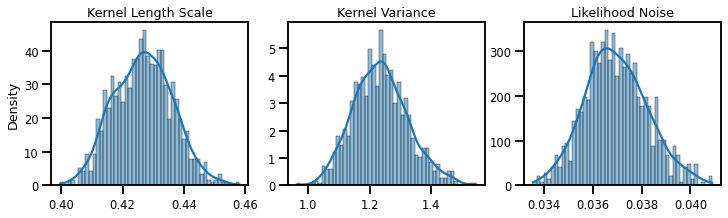

In [30]:
# Plot posteriors for the parameers
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

sns.histplot(ax=ax[0], x=posterior_samples['lengthscale'], kde=True, bins=50, stat='density')
sns.histplot(ax=ax[1], x=posterior_samples['variance'], kde=True, bins=50, stat='density')
sns.histplot(ax=ax[2], x=posterior_samples['obs_noise'], kde=True, bins=50, stat='density')

ax[0].set(title='Kernel Length Scale')
ax[1].set(title='Kernel Variance', ylabel="")
ax[2].set(title='Likelihood Noise', ylabel="")

plt.show()

#### Median Parameters

In [31]:
def get_median_parameters(samples: dict)-> dict:
    median_params = {}
    for ikey, iarray  in samples.items():
        median_params[ikey] = jnp.median(iarray)
    return median_params

In [32]:
median_params = get_median_parameters(posterior_samples)
pprint(median_params)

{'lengthscale': DeviceArray(0.42685495, dtype=float64),
 'obs_noise': Buffer(0.03687882, dtype=float64),
 'variance': Buffer(1.23434267, dtype=float64)}


### Predictions

In [33]:
from gpjax import mean, variance

predictive_mean = mean(posterior, median_params, xtest, x, y).squeeze()
predictive_covariance = variance(posterior, median_params, xtest, x, y).squeeze()

mu = predictive_mean
one_stddev = 1.96 * jnp.sqrt(jnp.diag(predictive_covariance))

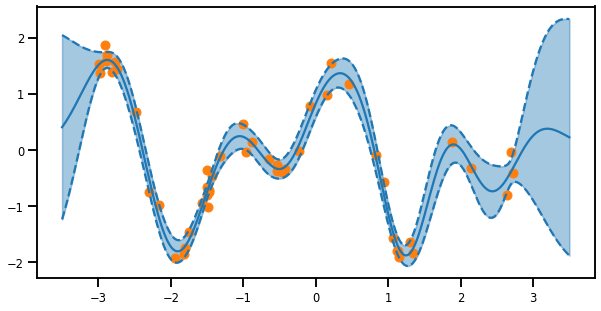

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu, color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.show()